# `track-mjx` - Mouse Reach Checkpoint Playground

This notebook is a playground for the saved checkpoints of `track-mjx`'s `mouse_reach` task with the `mouse_arm` walker. It allows you to load the intention network and perform various operations, such as inspecting the decoder with random intentions, generating trajectories, evaluating model performance, and visualizing results.

## Notes

- This notebook uses the `mouse_arm` walker and the model located at `/root/vast/eric/track-mjx/track_mjx/environment/walker/assets/mouse_arm/akira_torque.xml`.
- The checkpoint is loaded from `/root/vast/eric/track-mjx/model_checkpoints/mouse_arm/reaches_A36-1_2023-07-18_16-54-01_lightOff_tone_on_reach42_ik_250320_220239`.

In [1]:
# Setup environment variables
import os
from omegaconf import OmegaConf
from orbax import checkpoint as ocp

os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = os.environ.get("XLA_PYTHON_CLIENT_MEM_FRACTION", "0.4")

# Import necessary modules
import jax
import jax.numpy as jnp
import numpy as np
from track_mjx.agent import checkpointing
from track_mjx.agent.intention_network import Decoder, Encoder
from track_mjx.analysis.rollout import create_environment
from track_mjx.environment.custom_wrappers import EvalClipResetWrapper
from track_mjx.analysis.render import render_from_saved_rollout, display_video
from track_mjx.analysis.utils import save_to_h5py, load_from_h5py
from dm_control import mjcf as mjcf_dm
import mujoco
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import multiprocessing as mp
import functools
from track_mjx.io import load

## Part 0: Network Initialization and Checkpoint Loading

First, we load the checkpoint and initialize the environment for the `mouse_reach` task.

In [ ]:
try:
    from track_mjx.agent import checkpointing
    from orbax import checkpoint as ocp
    import yaml
    import jax
    from omegaconf import OmegaConf
    
    # Path to your config and checkpoint
    yaml_config_path = "/root/vast/eric/track-mjx/track_mjx/config/mouse-arm.yaml" #/root/vast/eric/track-mjx/track_mjx/environment/walker/assets/mouse_arm/akira_model_ghostpair.xml
    ckpt_path = "/root/vast/eric/track-mjx/model_checkpoints/mouse_arm/reaches_A36-5_2023-07-18_15-59-17_lightOff_tone_on_reach5_ik_250324_070449"
    
    # Load your yaml config
    with open(yaml_config_path, 'r') as f:
        yaml_config = yaml.safe_load(f)
    
    # Create OmegaConf object from your config
    cfg = OmegaConf.create(yaml_config)
    
    # Fix data_path by using only the first file
    data_files = cfg.data_path.split(',')
    if len(data_files) > 0:
        cfg.data_path = data_files[0]
        print(f"Using data file: {cfg.data_path}")
    
    # Add the required network dimension fields
    cfg.network_config.observation_size = 163  # Based on previous error messages
    cfg.network_config.reference_obs_size = 155
    cfg.network_config.action_size = 4  # For mouse arm joints
    
    # Try to directly examine the checkpoint structure
    mgr_options = ocp.CheckpointManagerOptions(
        create=False,
        step_prefix="PPONetwork"
    )
    ckpt_mgr = ocp.CheckpointManager(ckpt_path, options=mgr_options)
    step = ckpt_mgr.latest_step()
    print(f"Found checkpoint at step {step}")
    
    # Let's first try to load just the config to see what was saved
    try:
        saved_config = ckpt_mgr.restore(
            step,
            args=ocp.args.Composite(
                config=ocp.args.JsonRestore(),
            )
        )["config"]
        print("Saved config found:")
        if "network_config" in saved_config:
            for key, value in saved_config["network_config"].items():
                print(f"  {key}: {value}")
        else:
            print("  No network_config in saved config")
            print(f"  Available keys: {list(saved_config.keys())}")
    except Exception as e:
        print(f"Could not load saved config: {e}")
    
    # Create an abstract policy structure and try to load
    abstract_policy = checkpointing.make_abstract_policy(cfg)
    policy = ckpt_mgr.restore(
        step, 
        args=ocp.args.Composite(
            policy=ocp.args.StandardRestore(abstract_policy, strict=True)
        )
    )["policy"]
    
    print("\nSuccessfully loaded policy parameters")
    print("Policy structure:")
    jax.tree_util.tree_map(lambda x: print(f"  {x.shape}" if hasattr(x, "shape") else ""), policy[1])
    
except Exception as e:
    print(f"Failed to load policy: {e}")

Using data file: /root/vast/eric/stac-mjx/reaches_A36-1_2023-07-18_16-54-01_lightOff_tone_on_reach0_ik.h5
Found checkpoint at step 2644
Saved config found:
  arch_name: intention
  encoder_layer_sizes: [512, 512, 512]
  decoder_layer_sizes: [512, 512, 512]
  critic_layer_sizes: [512, 512, 512]
  intention_size: 3
  kl_weight: 1e-05

Successfully loaded policy parameters
Policy structure:
  (512,)
  (512,)
  (512,)
  (512,)
  (512,)
  (512,)
  (512,)
  (11, 512)
  (512,)
  (512, 512)
  (512,)
  (512, 512)
  (8,)
  (512, 8)
  (512,)
  (512,)
  (512,)
  (512,)
  (512,)
  (512,)
  (3,)
  (512, 3)
  (3,)
  (512, 3)
  (512,)
  (155, 512)
  (512,)
  (512, 512)
  (512,)
  (512, 512)


In [3]:
# Create environment with same config used during training
env = create_environment(cfg)
state = env.reset(jax.random.PRNGKey(0))

# Basic dimensions
print(f"Actual observation shape: {state.obs.shape}")
print(f"Reference observation size: {state.info.get('reference_obs_size')}")
print(f"Action size: {env.action_size}")

# System properties
print(f"System DOFs (nq): {env.sys.nq}")
print(f"System velocities (nv): {env.sys.nv}")
print(f"System actuators (nu): {env.sys.nu}")

# Walker properties
#if hasattr(env, "walker"):
    #print(f"Walker joint names: {env.walker.joint_names}")
    #print(f"Walker end effectors: {env.walker.end_effector_names}")

# Reference clip info
if hasattr(env, "_reference_clip") and env._reference_clip is not None:
    ref_clip = env._get_reference_clip(state.info)
    print(f"Reference clip length: {ref_clip.joints.shape[0]}")
    
# Timestep info
if hasattr(env, "_physics_steps_per_control_step"):
    print(f"Physics steps per control step: {env._physics_steps_per_control_step}")
#print(f"MJ model timestep: {env.sys.dt}")

# Print state info
print(f"\nState contains:")
for k, v in state.__dict__.items():
    if hasattr(v, "shape"):
        print(f"  {k}: shape={v.shape}")
    else:
        print(f"  {k}: {type(v)}")
        
# Print metrics available
print("\nAvailable metrics:")
for k, v in state.metrics.items():
    print(f"  {k}: {v}")

Using first file path: /root/vast/eric/stac-mjx/reaches_A36-1_2023-07-18_16-54-01_lightOff_tone_on_reach0_ik.h5
Loaded reference clip with 210 frames
Joint names: ['sh_elv', 'sh_extension', 'sh_rotation', 'elbow_joint']
env._steps_for_cur_frame: 1
env._steps_for_cur_frame: 5.0


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


Actual observation shape: (163,)
Reference observation size: 155
Action size: 4
System DOFs (nq): 4
System velocities (nv): 4
System actuators (nu): 4

State contains:
  pipeline_state: <class 'brax.mjx.base.State'>
  obs: shape=(163,)
  reward: shape=()
  done: shape=()
  metrics: <class 'dict'>
  info: <class 'dict'>

Available metrics:
  joint_reward: 0.0
  bodypos_reward: 0.0
  endeff_reward: 0.0
  ctrl_cost: 0.0
  ctrl_diff_cost: 0.0
  jerk_cost: 0.0
  energy_cost: 0.0


## Part 1: Decoder Initialization

Here, we initialize the decoder and load its parameters from the checkpoint.

## Part 1: Decoder Initialization

Here, we initialize the decoder and load its parameters from the checkpoint.

In [4]:
# Initialize the decoder
network_config = cfg["network_config"]
decoder = Decoder(network_config["decoder_layer_sizes"] + [network_config["action_size"] * 2])

# Load parameters
normalizer_param = policy[0]
decoder_raw = policy[1]["params"]["decoder"]
decoder_param = {"params": decoder_raw}

# Initialize action distribution
from brax.training import distribution
action_distribution = distribution.NormalTanhDistribution(event_size=network_config["action_size"])

# JIT-compiled functions
jit_env_reset = jax.jit(env.reset, static_argnames=("clip_idx",))
jit_env_step = jax.jit(env.step)
jit_apply = jax.jit(decoder.apply)

## Part 2: Decoder with Random Intentions

We explore how the decoder behaves when fed with random intentions.

In [ ]:
# # Initialize state
# rng = jax.random.PRNGKey(0)
# rng, env_rng = jax.random.split(rng)
# state = jit_env_reset(rng=env_rng, clip_idx=42)

# qposes_rollout = []
# for _ in range(210):
#     obs = jax.tree_map(lambda x: x, state.obs)
#     rng, subkey = jax.random.split(rng)
#     intentions = jax.random.normal(subkey, shape=(3,))
#     concatenated = jnp.concatenate([intentions, obs[..., network_config["reference_obs_size"]:]], axis=-1)
#     logits = jit_apply(decoder_param, concatenated)
#     action = action_distribution.mode(logits)
#     qposes_rollout.append(state.pipeline_state.qpos)
#     state = jit_env_step(state, action)

# # Render rollout
# # Get the reference poses from the environment
# ref_clip = env._get_reference_clip(state.info)
# reference_qpos = jnp.concatenate([
#     # For mouse-arm model, just need the joints
#     ref_clip.joints
# ], axis=-1)

# # Create the dictionary rollout expects
# rollout_dict = {
#     "qposes_ref": reference_qpos,
#     "qposes_rollout": jnp.array(qposes_rollout),
#     "walker_type": "mouse-arm"
# }

# # Render with proper arguments and ghostpair model
# frames = render_from_saved_rollout(
#     rollout=rollout_dict, 
#     walker_type="mouse-arm",  
#     max_frames=210,
# )

# render_fps = 200
# display_video(frames, framerate=render_fps)

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/tmp/ipykernel_2019880/159521752.py:8: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  obs = jax.tree_map(lambda x: x, state.obs)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dty

MuJoCo Rendering...


100%|██████████| 210/210 [00:00<00:00, 478.49it/s]


## Part 3: Recreate Recorded Rollout

We recreate the rollout using the recorded actions and intentions from the checkpoint.

In [ ]:
# Import necessary modules
from track_mjx.agent.intention_network import make_intention_policy, reparameterize
from brax.training.acme import running_statistics

# Setup network from scratch using the same factory function
policy_network = make_intention_policy(
    param_size=cfg.network_config.action_size * 2,  # For mean and std
    latent_size=3,  # Intention size 
    total_obs_size=cfg.network_config.observation_size,
    reference_obs_size=cfg.network_config.reference_obs_size,
    preprocess_observations_fn=running_statistics.normalize,
    encoder_hidden_layer_sizes=tuple(cfg.network_config.encoder_layer_sizes),
    decoder_hidden_layer_sizes=tuple(cfg.network_config.decoder_layer_sizes),
)

# Initialize state
rng = jax.random.PRNGKey(0)
rng, env_rng = jax.random.split(rng)
state = jit_env_reset(rng=env_rng, clip_idx=42)

# Set up action distribution
action_distribution = distribution.NormalTanhDistribution(event_size=cfg.network_config.action_size)

# Prepare inference function
def inference_fn(obs, key):
    # Run full network (normalizes obs internally)
    logits, mean, logvar, activations = policy_network.apply(policy[0], policy[1], obs, key, True)
    # Get deterministic action
    action = action_distribution.mode(logits)
    return action, mean, logvar, activations

# JIT compile for speed
jit_inference = jax.jit(inference_fn)

# Run rollout
qposes_rollout = []
intentions_rollout = []
actions_rollout = []
activations_rollout = []

for step in range(210):
    rng, step_rng = jax.random.split(rng)
    
    # Get action and track internal states
    action, mean, logvar, activations = jit_inference(state.obs, step_rng)
    
    # Store data
    qposes_rollout.append(state.pipeline_state.qpos)
    intentions_rollout.append(activations['intention'])
    actions_rollout.append(action)
    activations_rollout.append(activations)
    
    # Step environment
    state = jit_env_step(state, action)

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/root

In [ ]:
# Create the dictionary rollout expects
rollout_dict = {
    "qposes_ref": reference_qpos,
    "qposes_rollout": jnp.array(qposes_rollout),
    "walker_type": "mouse-arm"
}

# Render with proper arguments and ghostpair model
frames = render_from_saved_rollout(
    rollout=rollout_dict, 
    walker_type="mouse-arm",  
    max_frames=210,
)

render_fps = 200
display_video(frames, framerate=render_fps)

MuJoCo Rendering...


100%|██████████| 210/210 [00:00<00:00, 468.66it/s]


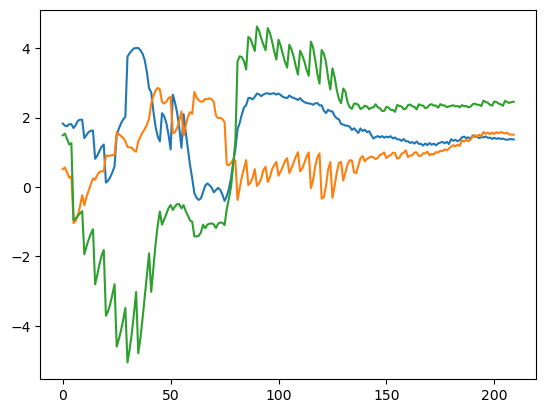

In [ ]:

plt.plot(intentions_rollout)
plt.show()

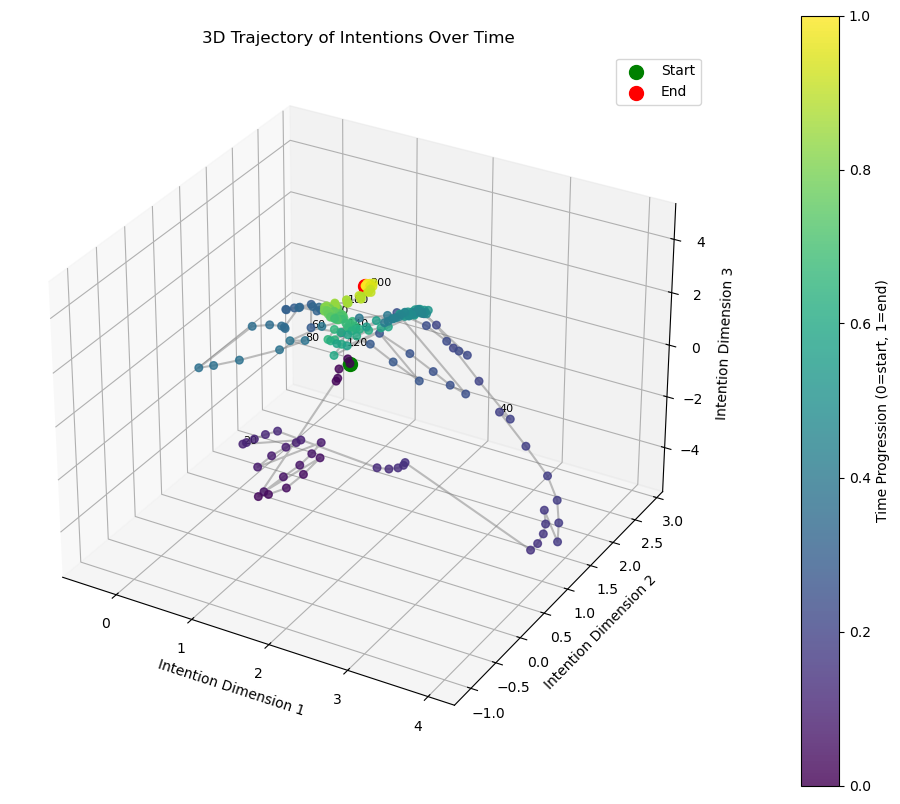

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

# Convert intentions to numpy arrays for easier plotting
intentions_np = np.array([np.array(intention) for intention in intentions_rollout])

# Create figure and 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z components
x = intentions_np[:, 0]
y = intentions_np[:, 1]
z = intentions_np[:, 2]

# Create time values for coloring
time_values = np.linspace(0, 1, len(x))

# Plot the trajectory as points and lines
scatter = ax.scatter(x, y, z, c=time_values, cmap='viridis', s=30, alpha=0.8)
ax.plot(x, y, z, c='gray', alpha=0.5)

# Add markers for start and end
ax.scatter(x[0], y[0], z[0], c='green', s=100, marker='o', label='Start')
ax.scatter(x[-1], y[-1], z[-1], c='red', s=100, marker='o', label='End')

# Add trajectory segment markers every N steps
step_interval = 20
for i in range(step_interval, len(x), step_interval):
    ax.text(x[i], y[i], z[i], f'{i}', color='black', fontsize=8)

# Add colorbar to show time progression
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Time Progression (0=start, 1=end)')

# Label axes and set title
ax.set_xlabel('Intention Dimension 1')
ax.set_ylabel('Intention Dimension 2')
ax.set_zlabel('Intention Dimension 3')
ax.set_title('3D Trajectory of Intentions Over Time')
plt.legend()
plt.show()

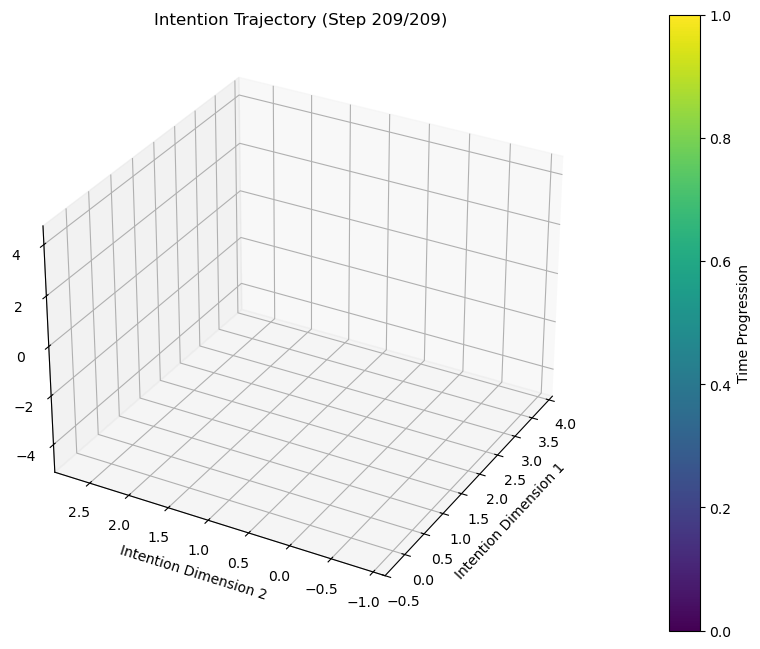

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
%matplotlib inline

# Convert intentions to numpy arrays for easier plotting
intentions_np = np.array([np.array(intention) for intention in intentions_rollout])

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z components
x = intentions_np[:, 0]
y = intentions_np[:, 1]
z = intentions_np[:, 2]

# Set consistent axis limits based on the full data
margin = 0.1
ax.set_xlim(np.min(x) - margin, np.max(x) + margin)
ax.set_ylim(np.min(y) - margin, np.max(y) + margin)
ax.set_zlim(np.min(z) - margin, np.max(z) + margin)

# Set up plot styling
ax.set_xlabel('Intention Dimension 1')
ax.set_ylabel('Intention Dimension 2')
ax.set_zlabel('Intention Dimension 3')
ax.set_title('Intention Trajectory Building Over Time')

# Initialize empty collections
line, = ax.plot([], [], [], 'gray', alpha=0.6, linewidth=1)
points = ax.scatter([], [], [], c=[], cmap='viridis', s=30, alpha=0.8)
current_point = ax.scatter([], [], [], c='red', s=80, marker='o')

# Colorbar setup
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array(np.linspace(0, 1, len(x)))
cbar = fig.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Time Progression')

# Initialization function
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    points._offsets3d = ([], [], [])
    current_point._offsets3d = ([], [], [])
    return line, points, current_point

# Update function
def update(frame):
    # Get data up to current frame
    x_frame = x[:frame+1]
    y_frame = y[:frame+1]
    z_frame = z[:frame+1]
    c_frame = np.linspace(0, 1, len(x))[:frame+1]
    
    # Update line
    line.set_data(x_frame, y_frame)
    line.set_3d_properties(z_frame)
    
    # Update points
    points._offsets3d = (x_frame, y_frame, z_frame)
    points.set_array(c_frame)
    
    # Update current point
    if frame > 0:
        current_point._offsets3d = ([x[frame]], [y[frame]], [z[frame]])
    
    # Rotate the view for better 3D perception
    ax.view_init(elev=30, azim=frame % 360)
    
    # Add step indicator in title
    ax.set_title(f'Intention Trajectory (Step {frame}/{len(x)-1})')
    
    return line, points, current_point

# Create animation
anim = FuncAnimation(fig, update, frames=len(x), 
                     init_func=init, blit=False, interval=50)

# Save as MP4 video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/tmp/intention_trajectory.mp4', writer=writer)

# Display the saved video
from IPython.display import Video
Video('/tmp/intention_trajectory.mp4', embed=True)

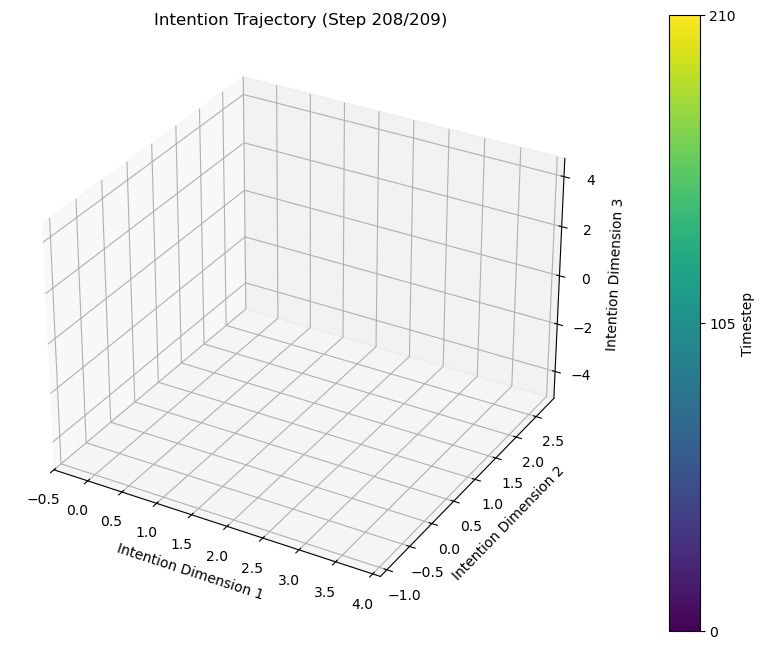

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
%matplotlib inline

# Convert intentions to numpy arrays for easier plotting
intentions_np = np.array([np.array(intention) for intention in intentions_rollout])

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z components
x = intentions_np[:, 0]
y = intentions_np[:, 1]
z = intentions_np[:, 2]

# Set consistent axis limits based on the full data
margin = 0.1
ax.set_xlim(np.min(x) - margin, np.max(x) + margin)
ax.set_ylim(np.min(y) - margin, np.max(y) + margin)
ax.set_zlim(np.min(z) - margin, np.max(z) + margin)

# Set up plot styling
ax.set_xlabel('Intention Dimension 1')
ax.set_ylabel('Intention Dimension 2')
ax.set_zlabel('Intention Dimension 3')
ax.set_title('Intention Trajectory Building Over Time')

# Create colors for all points
colors = plt.cm.viridis(np.linspace(0, 1, len(x)))

# Create line and points once
line, = ax.plot([], [], [], 'gray', alpha=0.5, linewidth=1)
current_point = ax.scatter([], [], [], color='red', s=100, marker='*')

# Colorbar setup
norm = plt.Normalize(0, len(x))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Dummy array
cbar = fig.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Timestep')
cbar.set_ticks([0, len(x)//2, len(x)])
cbar.set_ticklabels(['0', f'{len(x)//2}', f'{len(x)}'])

# Create a scatter plot that we'll update, not remove/recreate
scatter = ax.scatter([], [], [], c=[], cmap='viridis', norm=norm, s=30)

# Initialization function
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    scatter._offsets3d = ([], [], [])
    scatter.set_array(np.array([]))
    current_point._offsets3d = ([], [], [])
    return line, scatter, current_point

# Update function
def update(frame):
    # Get data up to current frame
    x_frame = x[:frame+1]
    y_frame = y[:frame+1]
    z_frame = z[:frame+1]
    
    # Update existing scatter plot with new positions and colors
    scatter._offsets3d = (x_frame, y_frame, z_frame)
    scatter.set_array(np.arange(frame+1))
    
    # Update line
    line.set_data(x_frame, y_frame)
    line.set_3d_properties(z_frame)
    
    # Update current point (highlight current position)
    if frame > 0:
        current_point._offsets3d = ([x[frame]], [y[frame]], [z[frame]])
    
    # Rotate the view slowly (uncomment if you want rotation)
    # ax.view_init(elev=30, azim=(frame//2) % 360)
    
    # Add step indicator in title
    ax.set_title(f'Intention Trajectory (Step {frame}/{len(x)-1})')
    
    return line, scatter, current_point

# Create animation with stride for efficiency
frame_stride = 2
selected_frames = range(0, len(x), frame_stride)

anim = FuncAnimation(fig, update, frames=selected_frames, 
                     init_func=init, blit=False, interval=100)

# Save as MP4 video (use lower resolution for faster rendering)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/tmp/intention_trajectory.mp4', writer=writer)

# Display the saved video
from IPython.display import Video
Video('/tmp/intention_trajectory.mp4', embed=True)

Joint angle range: -0.4713 to 0.8886 radians


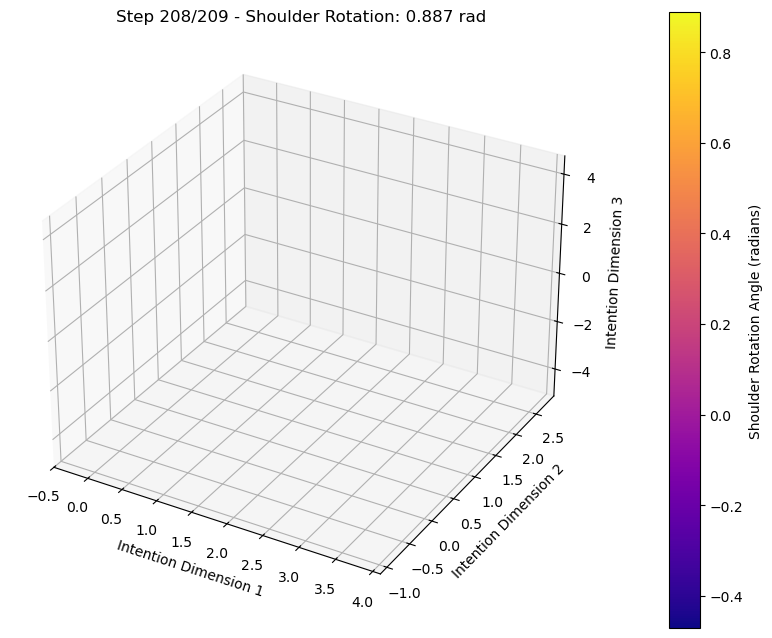

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
%matplotlib inline

# Convert intentions to numpy arrays for easier plotting
intentions_np = np.array([np.array(intention) for intention in intentions_rollout])

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z components of intentions
x = intentions_np[:, 0]
y = intentions_np[:, 1]
z = intentions_np[:, 2]

# Convert qposes_rollout to numpy for easier processing
qposes_np = np.array([np.array(qpos) for qpos in qposes_rollout])

# Extract sh_rotation joint angle (3rd joint - index 2)
# Assuming joint order is: sh_elv (0), sh_extension (1), sh_rotation (2), elbow_joint (3)
sh_rotation_angles = qposes_np[:, 2]  # Adjust index if joint ordering is different

print(f"Joint angle range: {np.min(sh_rotation_angles):.4f} to {np.max(sh_rotation_angles):.4f} radians")

# Set up colormap based on joint angle instead of time
norm = plt.Normalize(np.min(sh_rotation_angles), np.max(sh_rotation_angles))
cmap = plt.cm.plasma  # Different colormap for visual distinction

# Set consistent axis limits for intention space
margin = 0.1
ax.set_xlim(np.min(x) - margin, np.max(x) + margin)
ax.set_ylim(np.min(y) - margin, np.max(y) + margin)
ax.set_zlim(np.min(z) - margin, np.max(z) + margin)

# Set up plot styling
ax.set_xlabel('Intention Dimension 1')
ax.set_ylabel('Intention Dimension 2')
ax.set_zlabel('Intention Dimension 3')
ax.set_title('Intention Trajectory Colored by Shoulder Rotation Angle')

# Create line and points
line, = ax.plot([], [], [], 'gray', alpha=0.3, linewidth=1)
current_point = ax.scatter([], [], [], color='red', s=100, marker='*')

# Set up colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Shoulder Rotation Angle (radians)')

# Create scatter plot to update
scatter = ax.scatter([], [], [], c=[], cmap=cmap, norm=norm, s=30)

# Initialization function
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    scatter._offsets3d = ([], [], [])
    scatter.set_array(np.array([]))
    current_point._offsets3d = ([], [], [])
    return line, scatter, current_point

# Update function
def update(frame):
    # Get data up to current frame
    x_frame = x[:frame+1]
    y_frame = y[:frame+1]
    z_frame = z[:frame+1]
    angle_frame = sh_rotation_angles[:frame+1]
    
    # Update scatter with joint angle coloring
    scatter._offsets3d = (x_frame, y_frame, z_frame)
    scatter.set_array(angle_frame)
    
    # Update line
    line.set_data(x_frame, y_frame)
    line.set_3d_properties(z_frame)
    
    # Update current point
    if frame > 0:
        current_point._offsets3d = ([x[frame]], [y[frame]], [z[frame]])
    
    # Add step and angle indicator in title
    current_angle = sh_rotation_angles[frame] if frame < len(sh_rotation_angles) else 0
    ax.set_title(f'Step {frame}/{len(x)-1} - Shoulder Rotation: {current_angle:.3f} rad')
    
    return line, scatter, current_point

# Create animation with stride
frame_stride = 2
selected_frames = range(0, len(x), frame_stride)

anim = FuncAnimation(fig, update, frames=selected_frames, 
                    init_func=init, blit=False, interval=100)

# Save as MP4 video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/tmp/shoulder_rotation_intention.mp4', writer=writer)

# Display the video
from IPython.display import Video
Video('/tmp/shoulder_rotation_intention.mp4', embed=True)

MuJoCo Rendering...


 45%|████▌     | 95/210 [00:00<00:00, 488.70it/s]

100%|██████████| 210/210 [00:00<00:00, 464.31it/s]


Aligning animations with 210 frames
Joint angle range: -0.4713 to 0.8886 radians
Animation saved to /tmp/combined_animation.mp4


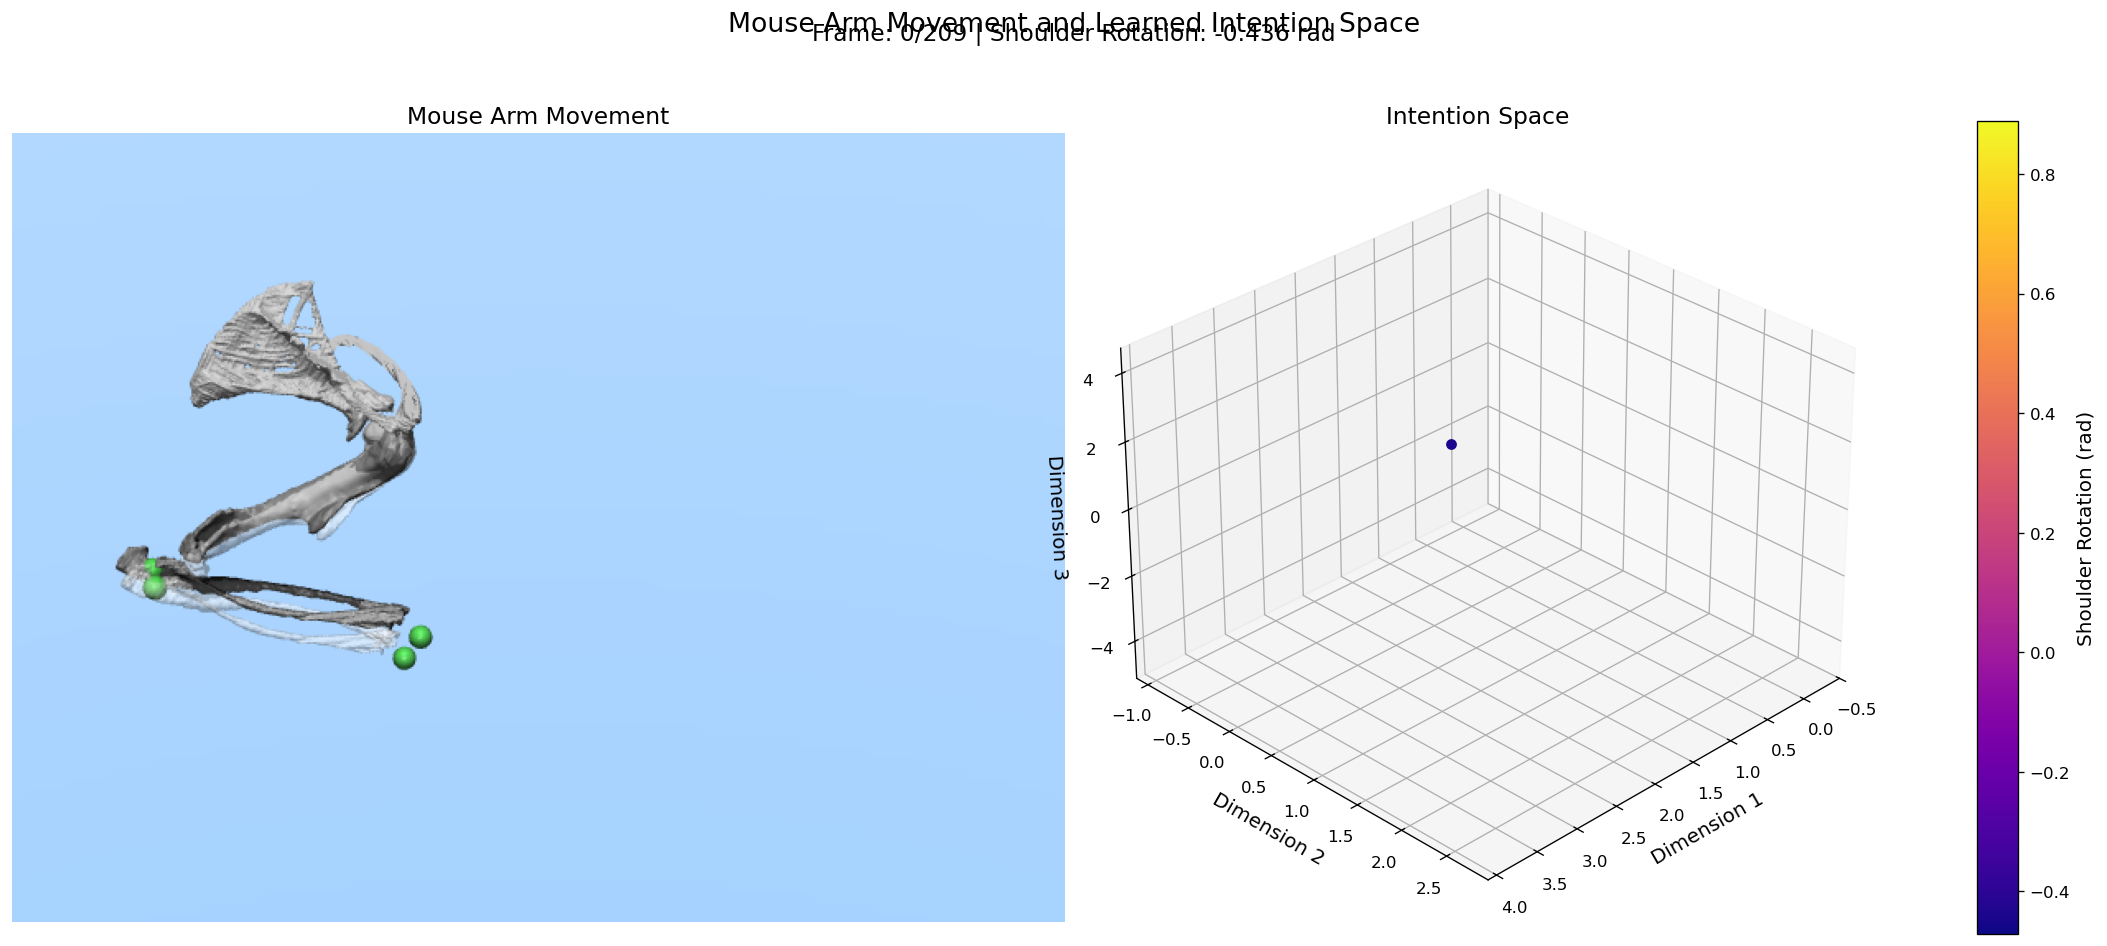

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import Video
%matplotlib inline

# First, create the dictionary for rollout rendering
rollout_dict = {
    "qposes_ref": reference_qpos,
    "qposes_rollout": jnp.array(qposes_rollout),
    "walker_type": "mouse-arm"
}

# Render all the mujoco frames
render_fps = 30  # Using 30fps for smoother animation
frames_mujoco = render_from_saved_rollout(
    rollout=rollout_dict, 
    walker_type="mouse-arm",  
    max_frames=210,
)

# Figure out how many frames we have
n_frames = min(len(frames_mujoco), len(intentions_rollout))
print(f"Aligning animations with {n_frames} frames")

# Set up data for intention plot
intentions_np = np.array([np.array(intention) for intention in intentions_rollout[:n_frames]])
qposes_np = np.array([np.array(qpos) for qpos in qposes_rollout[:n_frames]])
sh_rotation_angles = qposes_np[:, 2]  # Shoulder rotation joint

print(f"Joint angle range: {np.min(sh_rotation_angles):.4f} to {np.max(sh_rotation_angles):.4f} radians")

# Extract components
x = intentions_np[:, 0]
y = intentions_np[:, 1]
z = intentions_np[:, 2]

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(18, 8), dpi=120)

# Left subplot for MuJoCo rendering
ax1 = plt.subplot(121)
ax1.set_title("Mouse Arm Movement", fontsize=14)
ax1.axis('off')
mujoco_img = ax1.imshow(frames_mujoco[0])

# Right subplot for 3D intention space
ax2 = plt.subplot(122, projection='3d')
ax2.set_title("Intention Space", fontsize=14)
ax2.set_xlabel('Dimension 1', fontsize=12)
ax2.set_ylabel('Dimension 2', fontsize=12)
ax2.set_zlabel('Dimension 3', fontsize=12)

# Style the intention plot
margin = 0.1
ax2.set_xlim(np.min(x) - margin, np.max(x) + margin)
ax2.set_ylim(np.min(y) - margin, np.max(y) + margin)
ax2.set_zlim(np.min(z) - margin, np.max(z) + margin)
ax2.view_init(elev=30, azim=45)  # Set a good viewing angle

# Setup colormap based on shoulder rotation
norm = plt.Normalize(np.min(sh_rotation_angles), np.max(sh_rotation_angles))
cmap = plt.cm.plasma

# Colorbar for intention plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.1)
cbar.set_label('Shoulder Rotation (rad)', fontsize=12)

# Initialize empty plots for intention data
line, = ax2.plot([], [], [], 'gray', alpha=0.3, linewidth=1)
points = ax2.scatter([], [], [], c=[], cmap=cmap, norm=norm, s=30)
current_point = ax2.scatter([], [], [], color='red', s=100, marker='*')

# Initialize frame counter and angle display
frame_text = fig.text(0.5, 0.95, "", ha='center', fontsize=14)

# Animation update function
def update(frame):
    # Update MuJoCo frame
    mujoco_img.set_array(frames_mujoco[frame])
    
    # Get intention data up to current frame
    x_frame = x[:frame+1]
    y_frame = y[:frame+1]
    z_frame = z[:frame+1]
    angle_frame = sh_rotation_angles[:frame+1]
    
    # Update line in intention space
    line.set_data(x_frame, y_frame)
    line.set_3d_properties(z_frame)
    
    # Update points in intention space
    points._offsets3d = (x_frame, y_frame, z_frame)
    points.set_array(angle_frame)
    
    # Update current point
    if frame > 0:
        current_point._offsets3d = ([x[frame]], [y[frame]], [z[frame]])
    else:
        current_point._offsets3d = ([], [], [])
        
    # Update frame counter with joint angle
    current_angle = sh_rotation_angles[frame] if frame < len(sh_rotation_angles) else 0
    frame_text.set_text(f"Frame: {frame}/{n_frames-1} | Shoulder Rotation: {current_angle:.3f} rad")
    
    # Return all artists that were updated
    return mujoco_img, line, points, current_point, frame_text

# Add a title to the figure
fig.suptitle("Mouse Arm Movement and Learned Intention Space", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for title

# Create the animation
anim = FuncAnimation(fig, update, frames=n_frames, interval=1000/render_fps, blit=False)

# Save the animation
output_path = '/tmp/combined_animation.mp4'
writer = animation.FFMpegWriter(fps=render_fps, metadata=dict(artist='Track-MJX'), bitrate=5000)
anim.save(output_path, writer=writer)

# Display the video
print(f"Animation saved to {output_path}")
Video(output_path)